# Gravity model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%pylab inline
RootPath = '/Users/CQ/Documents/Project1/'
from datetime import datetime, timedelta, date
import time
from geopy.distance import vincenty
import geopandas as gp
import matplotlib.patches as mpatches
from descartes import PolygonPatch
from shapely.geometry.polygon import Polygon

plt.rcParams["figure.figsize"]=(20,9)

Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`


Populating the interactive namespace from numpy and matplotlib


## 1. Probabilistic Weight

### Construct a network with the probabilistic weight of link(a,b) defined as
### $$
link\ weight(a,b) = \Sigma_c\frac{t(c,a)\cdot(t(c,b)-\delta(a,b))}{T\cdot(t(c)-1)}
$$ where
* *t(c,a)* denotes the total number of tweets that user *c* has posted at location (in our case, zipcode) *a*
* $t(c) = \Sigma_a t(c,a)$
* $T = \Sigma_c t(c)$

## 2. Gravity Model
### On the other hand, the weight of links can be modeled as $$
link\ weight(a,b)=k\cdot w^{out}(a) \cdot w^{in}(b) \cdot f(d(a,b)),
$$ where
* $w(x)$ is the weight or customized centrality of the node $x$
* $f(d(a,b))$ denotes function with respect to distance between location $a$ and $b$, usually it dacays as distance increases.

In [2]:
twitter_file = pd.read_csv(RootPath + '2016_02_18_sintetic.csv')
twitter_file.columns = ['Date','Time','ZipCode','User','ID']
twitter_file.Time = pd.to_datetime(twitter_file.Time, unit='s') - timedelta(hours=5) ## UTS - 5h NYC
twitter_file.Date = twitter_file.Time.dt.date
USzipcode = pd.read_csv(RootPath + 'USzipcode_XY(II).csv')
USzipcode.columns = ['ZipCode','lat','lon']

zipPath = RootPath + 'nyc-zip-code-tabulation-areas-polygons.geojson'
geo_NY = gp.read_file(zipPath)[['geometry', 'postalCode', 'Shape_Area']]
geo_NY.postalCode = geo_NY.postalCode.astype(int)

Data_zip = twitter_file.ZipCode.unique()
country_zip = USzipcode.ZipCode
PLACES = sort( list( set(Data_zip) & set(country_zip) ) )

missing_zip = set(geo_NY.postalCode.unique()) - set(PLACES)

In [3]:
def Initiate_forKLBin(df):
    
    def Count_tweet(series):
        return (c[series.zip1] , c[series.zip2])
    
    def ProbNetWeight(series):
        delta = (series.zip1 == series.zip2)+0
        return sum(temp.loc[:,series.zip1] * (temp.loc[:,series.zip2] - delta)/T/(tc[ix_tc]-1))
    
    def Dist_Centr_Comp(df, city_ziplist = PLACES, map_ziplist = USzipcode):
        '''
        Extract zip codes' coordinates from USzipcode.csv, calculate the distance for each zip pair
        '''
        leng = len(df)
        ziplist = map_ziplist[map_ziplist.iloc[:,0].isin(city_ziplist)]
        zipdict = {int(ziplist.iloc[i,0]):(ziplist.iloc[i,1],ziplist.iloc[i,2]) for i in xrange(len(ziplist))}
        network = df.loc[:,['zip1','zip2']]
        distance = [vincenty(zipdict[network.zip1[i]], zipdict[network.zip2[i]]).miles for i in xrange(leng)]
        df['distance'] = distance
        return df

    def KLBin_init(df, bins=100):
        dataset = pd.DataFrame(df[df.distance > 0], copy = True)
        len1 = len(dataset)
        len2 = len(PLACES)
        #convert the rank into our 100-bin distribution
        dataset['DistRank'] = (dataset.distance.rank(method = 'min')-1)*100/len1        
        dataset.DistRank = dataset.DistRank.astype(int)
        
        K_label = ['K%d'%i for i in PLACES]
        L_label = ['L%d'%i for i in PLACES]
        bin_label = ['bin%d'%i for i in range(bins)]
        #bin_rank = (stat.rankdata(dataset.distance, 'min')-1)*bins/len1
        K = np.matrix(dataset.zip1).T * np.matrix(np.ones((1,len2))) == np.matrix(np.ones(len1)).T * np.matrix(PLACES)
        K = pd.DataFrame(K*1, columns = K_label)
        L = np.matrix(dataset.zip2).T * np.matrix(np.ones((1,len2))) == np.matrix(np.ones(len1)).T * np.matrix(PLACES)
        L = pd.DataFrame(L*1, columns = L_label)
        Bin = np.matrix(dataset.DistRank).T * np.matrix(np.ones((1,bins))) == np.matrix(np.ones(len1)).T * np.matrix(range(bins))
        Bin = pd.DataFrame(Bin*1, columns = bin_label)
        dataset.index = range(len1)
        data = pd.concat([dataset, K, L, Bin], axis = 1)
        data.fillna(0, inplace = True)
        return data

    if df.empty:
        return df
    else:
        data_zip = df.ZipCode.unique()
        places = sort( list( set(data_zip) & set(country_zip) ) )
        dataset = pd.DataFrame(df, copy = True)
        tweet_by_user = df['ZipCode'].groupby(df['User'])
        a = tweet_by_user.value_counts()
        b = a.unstack(level = -1).fillna(0)
        tweet_by_zip = dataset.groupby(dataset['ZipCode'])
        c = tweet_by_zip.count().ID
        #c is the series, containing number of tweets on each zip code
        user = np.sort(dataset.User.unique())
        #places = list(np.sort(dataset.ZipCode.unique()))
        b = pd.DataFrame(b, columns = PLACES, index = user)
        #b is the matrix where each entry b_{i,j} is the number of tweets that user i posted on zip code j
        tc = b.sum(axis = 1)
        #tc is the total number of tweets that each user has posted
        #note that b.sum() is the same as c above
        #select the index of tc larger than 1(in order to make all computation valid when we proceed to/
        #let (tc-1) sit on the denominator)
        ix_tc = tc > 1
        tc = tc[ix_tc]  #only consider those people who has posted more than once
        temp = b[ix_tc]  #only consider those people who has posted more than once
        T = temp.sum().sum()*1.0  #T is the total number of tweets posted by the users who has posted more than one tweet
    
        data = pd.DataFrame([(i,j) for i in places for j in places], columns=['zip1','zip2'])

        tweet_count = data.apply(Count_tweet, axis = 1)

        for i in range(2):
            data['tweet%d'%(i+1)] = [j[i] for j in tweet_count]

        data['weight'] = data.apply(ProbNetWeight, axis = 1)
        data = KLBin_init(Dist_Centr_Comp(data))
        return data

# Part 1, OLS test and showcase of out degree of zip codes in NYC

### Updated: we will focus on the dataset restricted before December 18, 2015, to avoid massive empty dataframes between December 19, 2015, and January 7, 2016.

In [27]:
restricted_data = twitter_file[twitter_file.Date <= date(2015, 12, 18)]

In [5]:
#data = Initiate_forKLBin(restricted_data)

In [7]:
# data.to_csv(RootPath + 'GravModel/Overall/Net2/Restricted_before_Dec19_OLS.csv',index = False)

In [28]:
data = pd.read_csv(RootPath + 'GravModel/Overall/Net2/Restricted_before_Dec19_OLS.csv')

In [29]:
fit_data = data[data.weight > 0]

new_X = pd.concat([fit_data.iloc[:,7:-100], np.log(fit_data.loc[:,'distance'])], axis=1)

Y1 = log(fit_data.weight)   #first model, only targeting link weight
Y2 = log(fit_data.weight * fit_data.tweet1)
#second model, let the dependent variable be (link weight * number of tweets)

result1 = sm.OLS(Y1,new_X).fit()
result2 = sm.OLS(Y2,new_X).fit()

In [30]:
Wout1 = pd.DataFrame([(i,result1.params.loc['K%d'%i]) for i in PLACES], columns=['postalCode', 'log_cent'])
Wout2 = pd.DataFrame([(i,result2.params.loc['K%d'%i]) for i in PLACES], columns=['postalCode', 'log_cent'])

Win1 = pd.DataFrame([(i,result1.params.loc['L%d'%i]) for i in PLACES], columns=['postalCode', 'log_cent'])
Win2 = pd.DataFrame([(i,result2.params.loc['L%d'%i]) for i in PLACES], columns=['postalCode', 'log_cent'])

In [31]:
tweet_by_zip = twitter_file.groupby(twitter_file['ZipCode'])
c = tweet_by_zip.count().ID

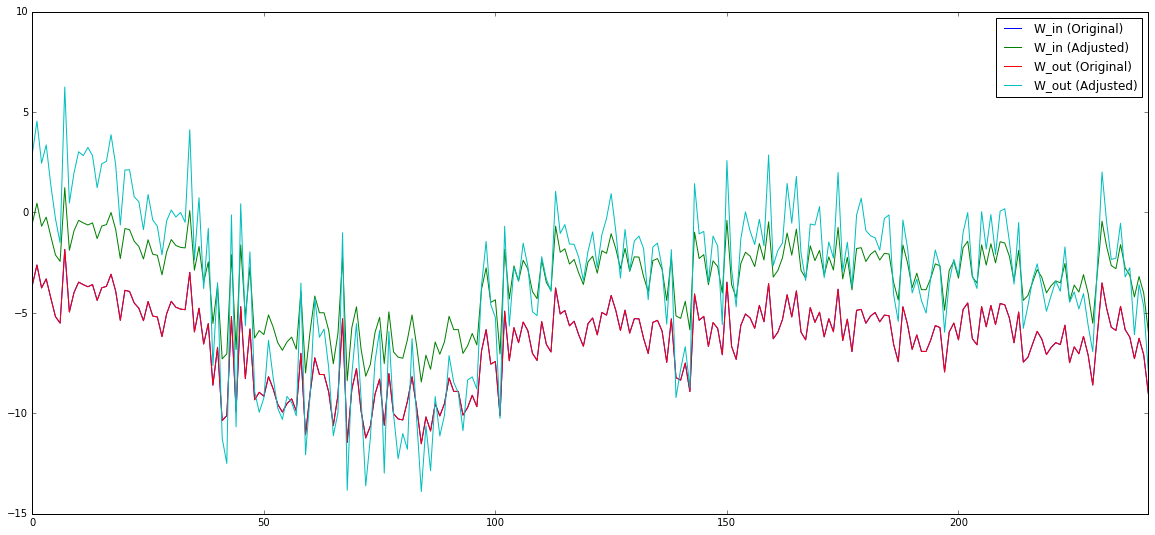

In [112]:
Show_All_fit = pd.concat( [Win1.log_cent,Win2.log_cent,Wout1.log_cent,Wout2.log_cent], axis =1)
Show_All_fit.columns = ['W_in (Original)','W_in (Adjusted)','W_out (Original)','W_out (Adjusted)']
Show_All_fit.plot()

In [32]:
def PlotMap(df, fig, zips = geo_NY, key = 'log_cent', layout = 111, loc_ix = 0, alpha = 0.7,
            mode = 1, density = False, cmap_name = 'RdPu', title = 'Community Map', plot =True):
    '''
    The function is for map plotting
    The arguments are:
    df       --- data frame
    fig      --- controls the figure to plot on
    key      --- the column name that user defined for determine color
    (default setting is 'log_cent' for log(centrality) that can be used for both in and out degree)
    (may be 'weight' for mode 2, heatmap)
    layout   --- determines the subplot layout, default at 111
    loc_ix   --- the plot locatin index
    mode     --- 1 is for integer partitions, such as groups or clusters
             --- 2 is for non-integer partition, such as heatmap
    density  --- False for regular plotting
             --- True for density plotting (divided by its area)
    levels   --- the number of clusters if mode == 1
             --- else set it equal to 100 for heatmap (mode 2)
    
    '''
       
    ax = fig.add_subplot(layout + loc_ix)
    # if we are plotting partition
    if mode == 1:
        levels = 10
        p = zips.merge(df, on='postalCode', how='outer')
        m = len(p)
        p['part'] = p[key] - np.log(p.Shape_Area) if density else p[key]
        p['Rank'] = p.part.rank(method = 'min') * levels/m - 1.0/m
        p.Rank = p.Rank.fillna(-1).astype(int)
    # if we are plotting heatmap
    else:
        levels = 100
        p = zips.merge(df, on='postalCode', how='outer')
        m = len(p)
        p['part'] = p[key] - np.log(p.Shape_Area) if density else p[key]
        p['Rank'] = p.part.rank(method = 'min') * levels/m - 1.0/m
        p.Rank = p.Rank.fillna(-1).astype(int)
    color_func = matplotlib.cm.get_cmap(cmap_name)
    color = list(color_func(np.linspace(0,1,levels-1)))
    color.append([0.,0.,0.,1.])

    #creating percentage interval along with its labels
    percent = [i*100.0/levels for i in xrange(levels)]
    percent_label = ["{:2.0f}".format(percent[i])+'~'+"{:2.0f}".format(percent[i+1])+'%'
                     for i in xrange(levels - 1)]
    percent_label.append('> '+"{:2.0f}".format(percent[-1])+'%')
    interval = [np.percentile(p.part.dropna(), i) for i in percent]
    interval_label = ["({:2.2f}".format(interval[i])+'~'+"{:2.2f}".format(interval[i+1])+')'
                      for i in xrange(levels - 1)]
    interval_label.append('(> '+"{:2.2f}".format(interval[-1])+')')
    label = [percent_label[i]+' '+interval_label[i] for i in xrange(levels)]
    
    missing_zips = sort (list (set(zips.postalCode.unique()) - set(PLACES)) )
    if len(missing_zips) > 0:
        label.append('NO DATA')
        color.append([1,0,0,1])
    #part = [label[i] for i in p.Rank]

    #color = [[0.3+0.7*i,0.9*i,1] for i in np.linspace(1,0,levels-1)]
    #color.append([0.1,0,1])
    for s in xrange(m):
        poly = Polygon(p.geometry[s])
        c = color[p.Rank[s]][0:3]
        ax.add_patch(PolygonPatch(poly, fc = c, ec = 'k', alpha = alpha, zorder = 2))
      
    handles = [mpatches.Patch( color = color[i][0:3], label=label[i]) for i in xrange(len(color))]
    if plot:
        plt.legend(handles = handles, loc=2)
    plt.title(title, fontweight = 'bold', size = 18)
    ax.axis('scaled')

### So after calculating all $link(a,b)$, we run linear regression by taking logarithm on both sides
### A few notes:
* **Original model** uses link weight directly from the formula:
$$
log(weight_{a,b}) \sim log(w_a^{out}) + log(w_b^{in}) + log(f(d(a,b))
$$
* **Adjusted model** uses (link weight) * (number of tweets from origin) instead:
$$
log(weight_{a,b}) + log(number\ of\ tweets\ at\ a) \sim log(w_a^{out}) + log(w_b^{in}) + log(f(d(a,b))
$$
* NYC has about 240~250 zip codes, so we have 242 terms each(from twitter data) to be fit, for both $W^{out}$ and $W^{in}$
* For $f(d(a,b))$, we used a custom binned function to seperate all distance data into 100 subcategories based on its position between percentiles, so we have to fit an additional amount of 100 of distance bin, then observe the relationship between the coefficients and the distance within each bin

### On the following pages, we use heatmap to showcase both models for comparison. As we can see from the plot, adding $log(number\ of\ tweets\ at\ a)$ does significantly change the look of $W_a^{out}$, but $W_b^{in}$ appears little difference

In [102]:
missing_zip

{10043, 10155, 10162, 11096, 11451}

In [37]:
postalCode = [int(str(i)[1:]) for i in W_in_TS.index]

In [44]:
trial = pd.DataFrame({'postalCode':postalCode, 'log_cent':list(W_in_TS.iloc[:,0])})

In [61]:
W_in_TS

,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,...,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12
L83,-1.548485,-2.955131,-3.211688,-2.776694,-2.025987,-1.986529,-2.294665,-2.850606,0,0,...,0,0,0,-2.165562,-2.536292,-2.848838,-2.580401,-2.513072,-2.846581,-2.811258
L10001,-2.197835,-2.117267,-1.732228,-1.981826,-1.716409,-1.797653,-1.933867,-2.383172,0,0,...,0,0,0,-2.065401,-2.049289,-2.444994,-2.098421,-2.074313,-2.050490,-1.991567
L10002,-1.520677,-3.160009,-2.811054,-2.080860,-2.964398,-3.717152,-4.516204,-2.564469,0,0,...,0,0,0,-2.047537,-3.135086,-3.027977,-2.341500,-2.323338,-3.216871,-3.019324
L10003,-2.738689,-2.823435,-2.489535,-2.329774,-2.392183,-2.615240,-3.062905,-3.079858,0,0,...,0,0,0,-2.749141,-2.367120,-2.777670,-2.464368,-2.731659,-2.536997,-2.440818
L10004,-2.065835,-3.835265,-3.604058,-3.503614,-3.002185,-3.470064,-4.020173,-3.974605,0,0,...,0,0,0,-3.762064,-3.475143,-3.317753,-2.640709,-3.811831,-3.412442,-3.752380
L10005,-2.278701,-4.491026,-4.753660,-3.645602,-4.479853,-3.768826,-4.356421,-3.852273,0,0,...,0,0,0,-3.954661,-4.178105,-4.474431,-3.917279,-4.392745,-2.976285,-4.495540
L10006,0.000000,-5.322305,-4.019438,-4.260856,-4.307126,-3.738944,-3.954301,-4.366782,0,0,...,0,0,0,-3.341625,-5.244058,-5.000806,-5.115986,-2.364737,-4.319384,-4.263889
L10007,-2.291319,-1.616955,-1.433369,-1.168310,-1.099205,-1.438249,-1.535790,-1.636646,0,0,...,0,0,0,-1.254767,-1.308683,-1.201818,-1.250252,-1.255277,-1.132908,-1.509749
L10009,-0.812370,-2.489099,-2.606863,-2.414471,-3.376826,-4.157271,-4.558265,-2.731375,0,0,...,0,0,0,-4.243227,-2.543309,-3.172847,-4.041864,-4.328482,-2.998081,-2.513965
L10010,-2.144049,-3.156833,-3.094383,-3.197666,-2.688912,-3.587385,-3.193412,-3.393107,0,0,...,0,0,0,-2.771217,-3.049378,-3.274481,-3.164822,-3.125596,-2.901076,-3.444791


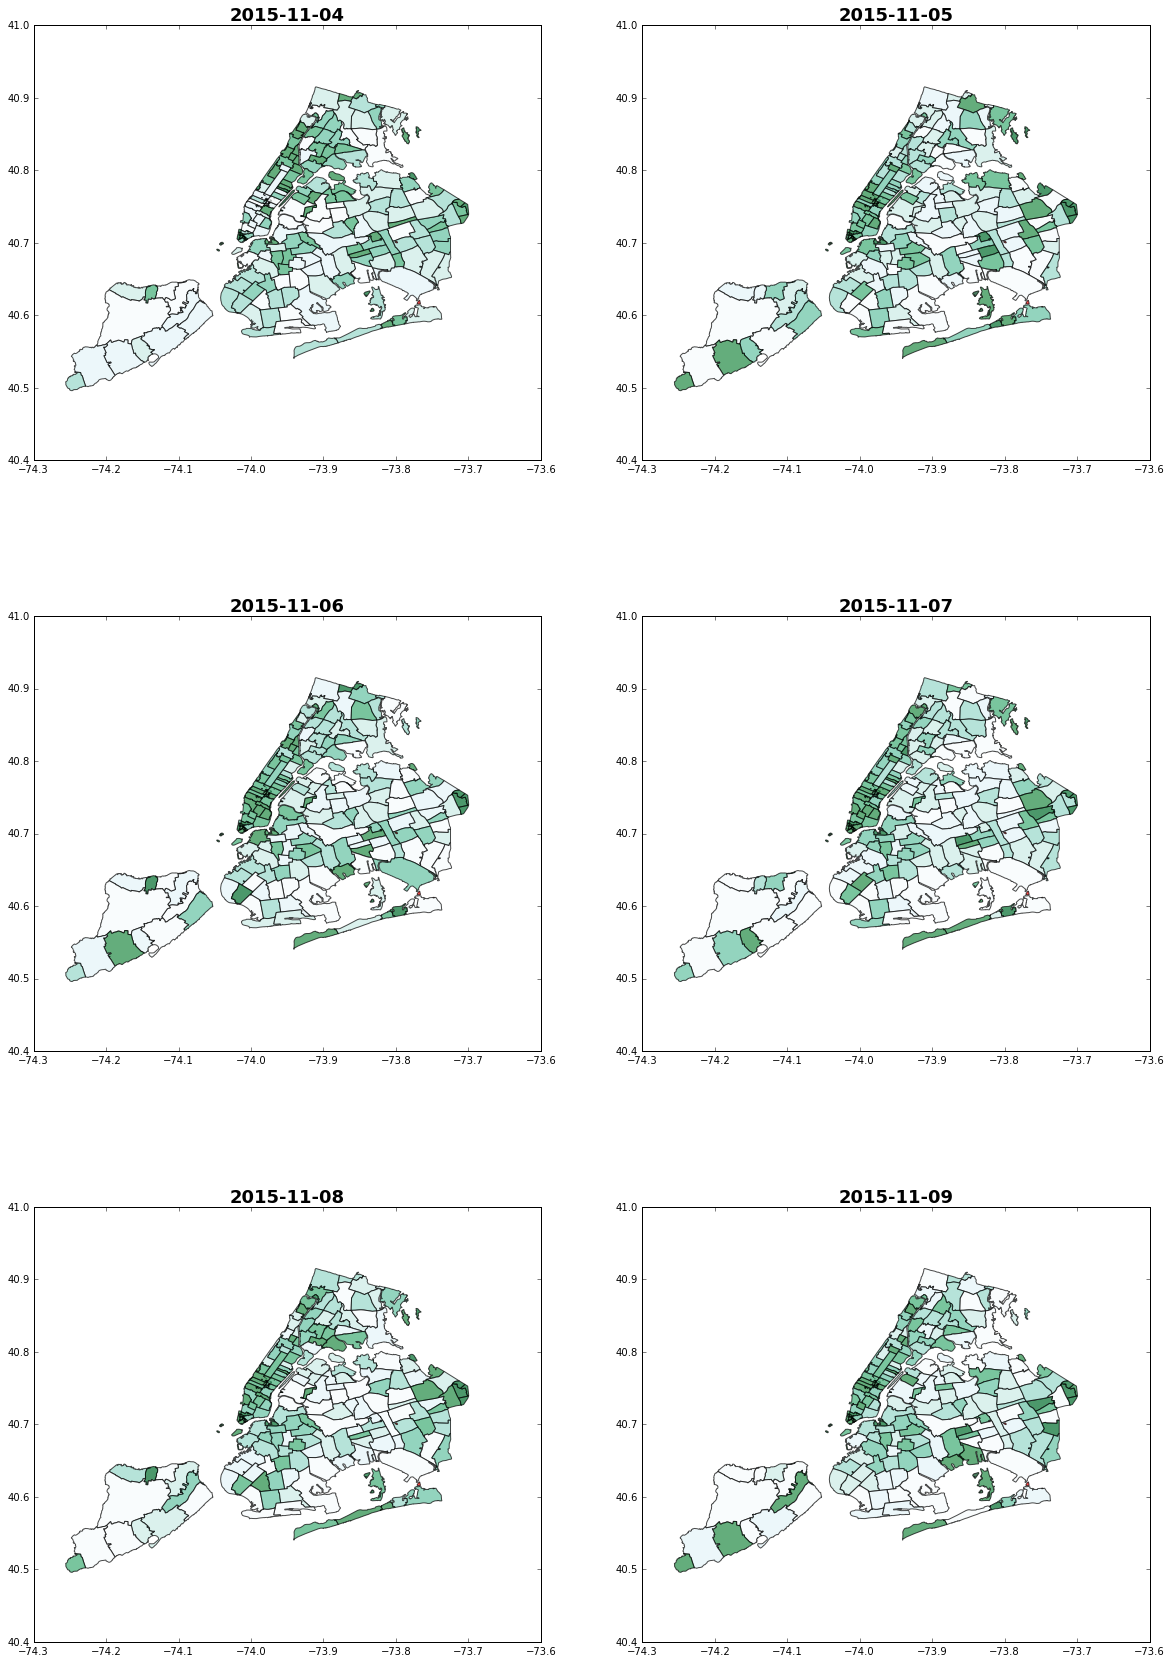

In [60]:
fig8 = plt.figure(figsize=(20,30))
for i in range(6):
    trial = pd.DataFrame({'postalCode':postalCode, 'log_cent':list(W_in_TS.iloc[:,i])})
    PlotMap(trial, fig8, title = W_in_TS.columns[i],layout = 321, loc_ix = i, cmap_name = 'BuGn', density=True, plot=False)

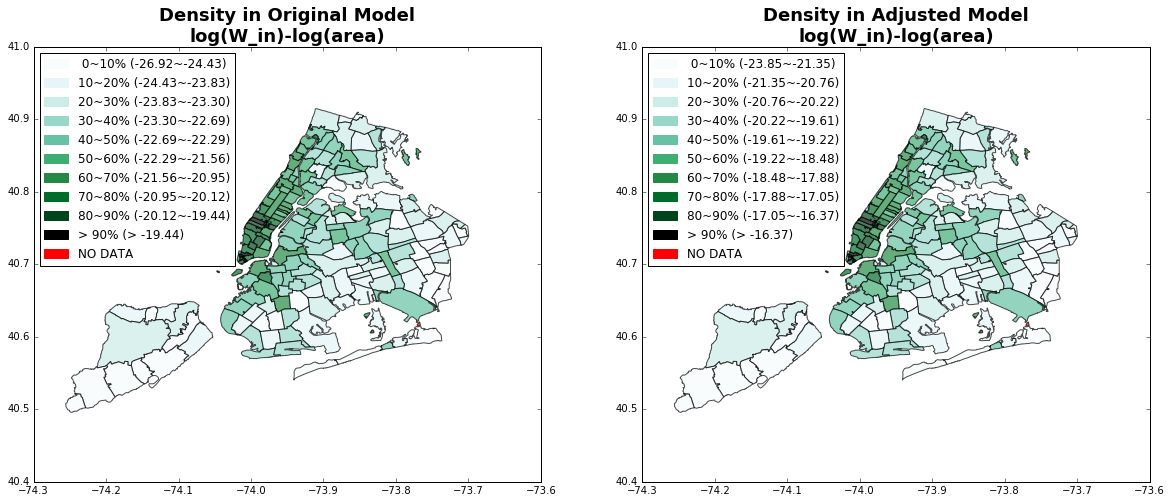

In [116]:
fig3 = plt.figure(figsize=(20,30))
PlotMap(Win1, fig3, title = 'Density in Original Model\nlog(W_in)-log(area)',
        layout = 121, loc_ix = 0, cmap_name = 'BuGn', density=True)
PlotMap(Win2, fig3, title = 'Density in Adjusted Model\nlog(W_in)-log(area)',
        layout = 121, loc_ix = 1, cmap_name = 'BuGn', density=True)

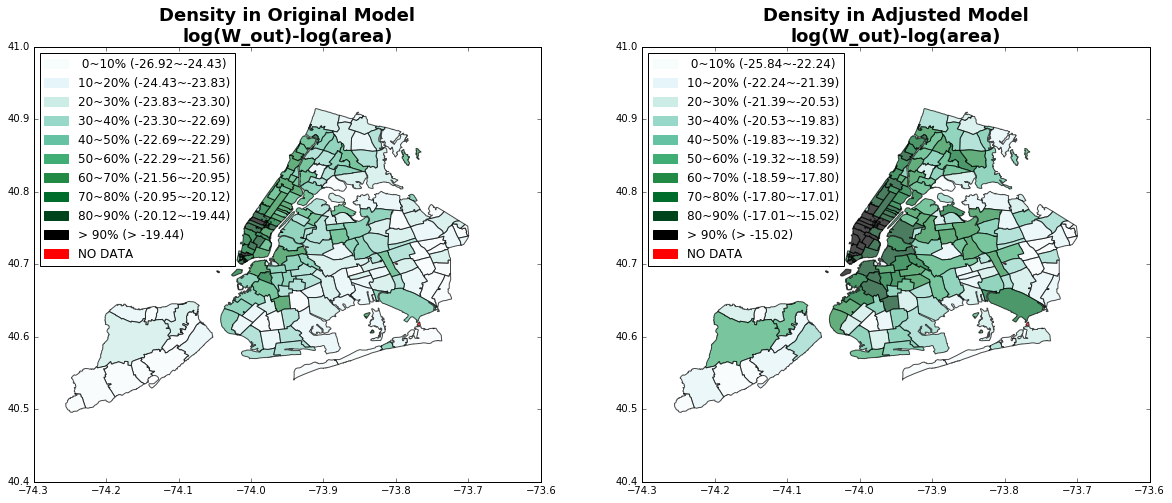

In [117]:
fig4 = plt.figure(figsize=(20,30))
PlotMap(Wout1, fig4, title = 'Density in Original Model\nlog(W_out)-log(area)',
        layout = 121, loc_ix = 0, cmap_name = 'BuGn', density=True)
PlotMap(Wout2, fig4, title = 'Density in Adjusted Model\nlog(W_out)-log(area)',
        layout = 121, loc_ix = 1, cmap_name = 'BuGn', density=True)

## We take a glance at the relationship of $ln(W^{out}_i)$ vs $ln(T_i)$ and $ln(W^{in}_i)$ vs $ln(T_i)$
## where $T_i$ denotes the number of tweets posted within zip code $i$

In [118]:
LogNum_of_tweets = pd.DataFrame({'postalCode':c.index, 'log(tweets)':np.log(c.values)})

In [161]:
def Draw_CI_for_OLS(X,Y):
    X1 = sm.add_constant(X)
    result = sm.OLS(Y,X1).fit()
    (d,c) = result.params

    plt.plot(X, Y, 'b.', label = 'Observations')
    plt.plot(X,  c*X+d, '-r', lw=2, label='Fitted line')
    print('The coefficients of this model are: a = %f, b = %f'%(c,d))
    print('The R square of this model is %f'%result.rsquared)

    y_err = Y-c*X-d
    p_x = np.arange(X.min(),X.max(),0.2)
    # now calculate confidence intervals for new test x-series
    t = 2.327               # appropriate t value (where n=242, two tailed 98%, it's practically normal distribution)
    s_err = np.sum(y_err**2)   # sum of the squares of the residuals
    n = len(X)
    confs = t * np.sqrt( (s_err/(n-2)) * (1.0/n + (p_x-X.mean())**2 / (np.sum(X**2)-n*(X.mean()**2)) ) )
    predict = t * np.sqrt( (s_err/(n-2)) * (1+ 1.0/n + (p_x-X.mean())**2 / (np.sum(X**2)-n*(X.mean()**2)) ) )
    p_y = c*p_x + d
    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower_ci = p_y - confs
    upper_ci = p_y + confs
    lower_pred = p_y - predict
    upper_pred = p_y + predict
    # plot confidence limits
    plt.plot(p_x,lower_ci,'g-',lw = 2, label='Lower confidence limit (98%)')
    plt.plot(p_x,upper_ci,'g-',lw = 2, label='Upper confidence limit (98%)')
    plt.plot(p_x,lower_pred,'c--',lw = 2, label='Lower prediction limit')
    plt.plot(p_x,upper_pred,'c--',lw = 2, label='Upper prediction limit')
    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=18)
    
    #plt.show()
    return result

The coefficients of this model are: a = 0.894480, b = -12.056657
The R square of this model is 0.918590


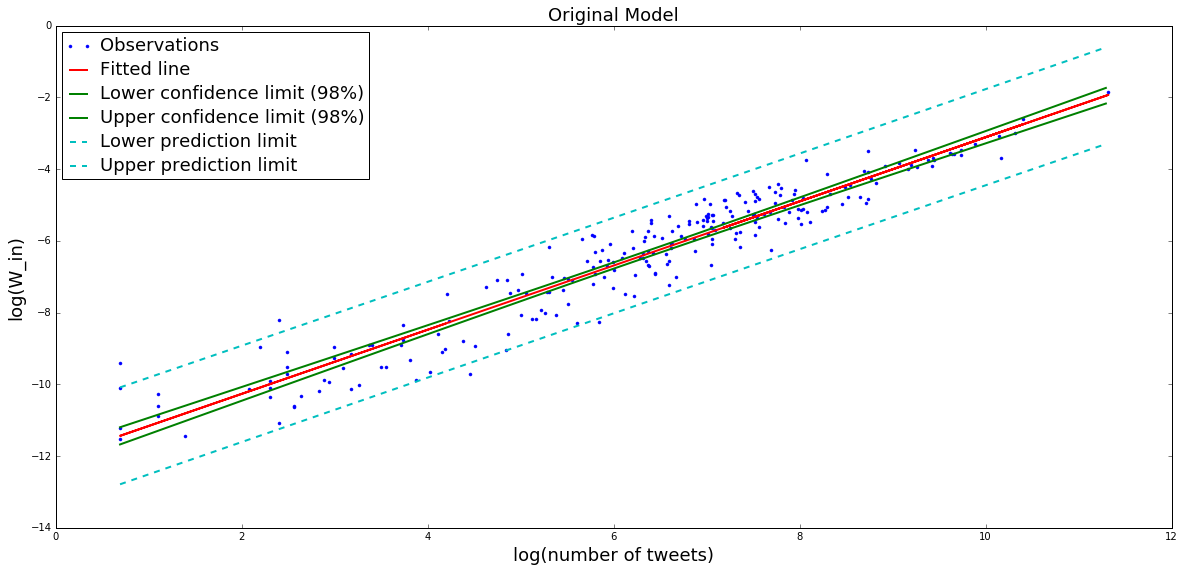

In [164]:
WIvsT1 = Draw_CI_for_OLS(LogNum_of_tweets['log(tweets)'],Win1['log_cent'])
plt.title('Original Model',fontsize=18)
plt.ylabel('log(W_in)',fontsize=18)
plt.xlabel('log(number of tweets)',fontsize=18)
plt.show()

The coefficients of this model are: a = 0.894480, b = -8.982664
The R square of this model is 0.918590


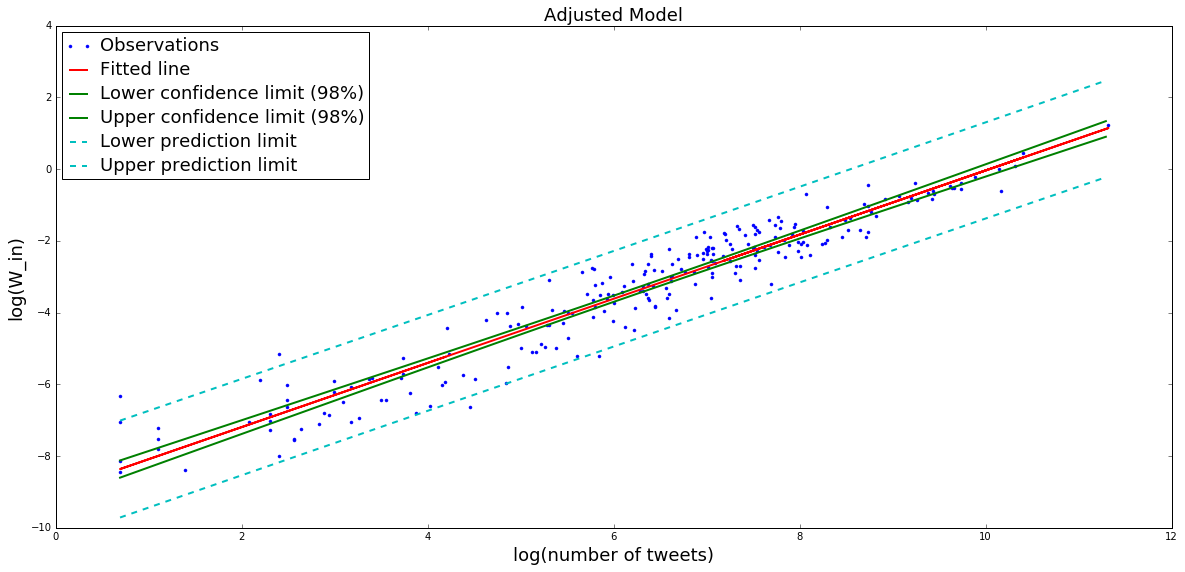

In [165]:
WIvsT2 = Draw_CI_for_OLS(LogNum_of_tweets['log(tweets)'],Win2['log_cent'])
plt.title('Adjusted Model',fontsize=18)
plt.ylabel('log(W_in)',fontsize=18)
plt.xlabel('log(number of tweets)',fontsize=18)
plt.show()

In [158]:
WIvsT2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_cent   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     2708.
Date:                Sun, 05 Jun 2016   Prob (F-statistic):          1.03e-132
Time:                        18:57:27   Log-Likelihood:                -206.85
No. Observations:                 242   AIC:                             417.7
Df Residuals:                     240   BIC:                             424.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -8.9827      0.114    -78.680      0.000        -9.208    -8.758
log(tweets)     0.8945      0.017     52.039      0.000         0.861     0.928
==============================================================================
Omnibus:                        1.920   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.383   Jarque-Bera (JB):                1.755
Skew:                           0.033   Prob(JB):                        0.416
Kurtosis:                       3.412   Cond. No.                         21.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
exp(-8.982664)

0.00012556788867917434

### So the values of $ln(W^{out}_i)$ are  showing strong linear correlation with $ln(T_i)$, which inspires us to predict $ln(W^{out}_i)$ as long as $T_i$ are available.
### And the model looks like this $$ln(W^{out}_i) \approx 0.8945 \cdot ln(T_i) -8.9827$$ or equivalently, $$W^{out}_i \approx  0.0001256 \cdot T^{0.8945}_i$$

## And it's worth noticing that the relationship between $W^{out}_i$ and $T_i$ is underlinear, 1 is not even in our 95% confidence interval (upper CI limit is 0.928 as shown above).

# Part 2, distance function and coefficients (see if they vary significantly over time) --conducted with model $$log(link(a,b)) \sim log(W_a^{out}) + log(W_b^{in}) + \gamma \cdot log(Dist)$$

Overall fitting, $\gamma$ is equal to:

In [105]:
result2.params[-1]

-1.0206520769233718

## A) Split dataset into sub-categories according to date

In [3]:
start_date = twitter_file.iloc[0,0]
end_date = twitter_file.iloc[-1,0]
day_count = (end_date-start_date).days + 1
DateList = [start_date + timedelta(n) for n in xrange(day_count)]

In [ ]:
# for single_day in DateList:
#     df = pd.read_csv(RootPath + '/GravModel/TimeSeries/General/'+str(single_day)+'.csv')
#     df = Initiate_forKLBin(df)
#     df.to_csv(RootPath + '/GravModel/TimeSeries/Reboot/'+str(single_day)+'.csv', index=False)

## B) Run OLS for each day and store coefficients $\gamma$

In [179]:
def Dist_Exponent(df):
    if df.empty:
        return 0
    else:
        data = df[df.weight > 0]
        new_X = pd.concat([data.iloc[:,7:-100], np.log(data.loc[:,'distance'])], axis=1)
        Y2 = log(data.weight * data.tweet1)
#second model, let the dependent variable be (link weight * number of tweets)
        result = sm.OLS(Y2,new_X).fit()
        return result.params[-1]

In [5]:
def ALL_params(df):
    if df.empty:
        return 0
    else:
        data = df[df.weight > 0]
        new_X = pd.concat([data.iloc[:,7:-100], np.log(data.loc[:,'distance'])], axis=1)
        Y2 = log(data.weight * data.tweet1)
#second model, let the dependent variable be (link weight * number of tweets)
        result = sm.OLS(Y2,new_X).fit()
        return result.params

params = range(len(DateList))
for single_day in DateList:
    df = pd.read_csv(RootPath + 'GravModel/TimeSeries/Reboot/'+str(single_day)+'.csv')
    params[DateList.index(single_day)] = ALL_params(df)

ddd = pd.DataFrame()
for single_day in DateList:
    ddd[str(single_day)] = params[DateList.index(single_day)]

W_in_TS = ddd.iloc[242:-1,:]

In [25]:
W_in_TS

,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,...,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12
L83,-1.548485,-2.955131,-3.211688,-2.776694,-2.025987,-1.986529,-2.294665,-2.850606,0,0,...,0,0,0,-2.165562,-2.536292,-2.848838,-2.580401,-2.513072,-2.846581,-2.811258
L10001,-2.197835,-2.117267,-1.732228,-1.981826,-1.716409,-1.797653,-1.933867,-2.383172,0,0,...,0,0,0,-2.065401,-2.049289,-2.444994,-2.098421,-2.074313,-2.050490,-1.991567
L10002,-1.520677,-3.160009,-2.811054,-2.080860,-2.964398,-3.717152,-4.516204,-2.564469,0,0,...,0,0,0,-2.047537,-3.135086,-3.027977,-2.341500,-2.323338,-3.216871,-3.019324
L10003,-2.738689,-2.823435,-2.489535,-2.329774,-2.392183,-2.615240,-3.062905,-3.079858,0,0,...,0,0,0,-2.749141,-2.367120,-2.777670,-2.464368,-2.731659,-2.536997,-2.440818
L10004,-2.065835,-3.835265,-3.604058,-3.503614,-3.002185,-3.470064,-4.020173,-3.974605,0,0,...,0,0,0,-3.762064,-3.475143,-3.317753,-2.640709,-3.811831,-3.412442,-3.752380
L10005,-2.278701,-4.491026,-4.753660,-3.645602,-4.479853,-3.768826,-4.356421,-3.852273,0,0,...,0,0,0,-3.954661,-4.178105,-4.474431,-3.917279,-4.392745,-2.976285,-4.495540
L10006,0.000000,-5.322305,-4.019438,-4.260856,-4.307126,-3.738944,-3.954301,-4.366782,0,0,...,0,0,0,-3.341625,-5.244058,-5.000806,-5.115986,-2.364737,-4.319384,-4.263889
L10007,-2.291319,-1.616955,-1.433369,-1.168310,-1.099205,-1.438249,-1.535790,-1.636646,0,0,...,0,0,0,-1.254767,-1.308683,-1.201818,-1.250252,-1.255277,-1.132908,-1.509749
L10009,-0.812370,-2.489099,-2.606863,-2.414471,-3.376826,-4.157271,-4.558265,-2.731375,0,0,...,0,0,0,-4.243227,-2.543309,-3.172847,-4.041864,-4.328482,-2.998081,-2.513965
L10010,-2.144049,-3.156833,-3.094383,-3.197666,-2.688912,-3.587385,-3.193412,-3.393107,0,0,...,0,0,0,-2.771217,-3.049378,-3.274481,-3.164822,-3.125596,-2.901076,-3.444791


In [186]:
# Coefficients = range(len(DateList))
# for single_day in DateList:
#     df = pd.read_csv(RootPath + 'GravModel/TimeSeries/Reboot/'+str(single_day)+'.csv')
#     Coefficients[DateList.index(single_day)] = Dist_Exponent(df)

Restriced data before Dec.19

In [187]:
# Coefficients = pd.DataFrame( {'Date':DateList, 'Gamma':Coefficients} )
# Coefficients.to_csv(RootPath + 'GravModel/TimeSeries/Dist_Exponent.csv', index = False)

In [37]:
# Coefficients = pd.read_csv(RootPath + '/GravModel/TimeSeries/Coefficients_ProbNet.csv')[:45]

In [224]:
Exponent = Coefficients.loc[:44,'Gamma']
markers_on = [3, 4, 10, 11, 17, 18, 24, 25, 31, 32, 38, 39]
mask = Exponent.index.isin(markers_on)
weekdays_a = Exponent[~mask]
weekends_a = Exponent[mask]

In [216]:
weekdays_a[weekdays_a!=0].mean()

-0.5934047396504404

In [217]:
weekdays_a[weekdays_a!=0].std()

0.1251591805644174

In [218]:
weekends_a[weekends_a!=0].mean()

-0.7410748539878304

In [219]:
weekends_a[weekends_a!=0].std()

0.04913154793166992

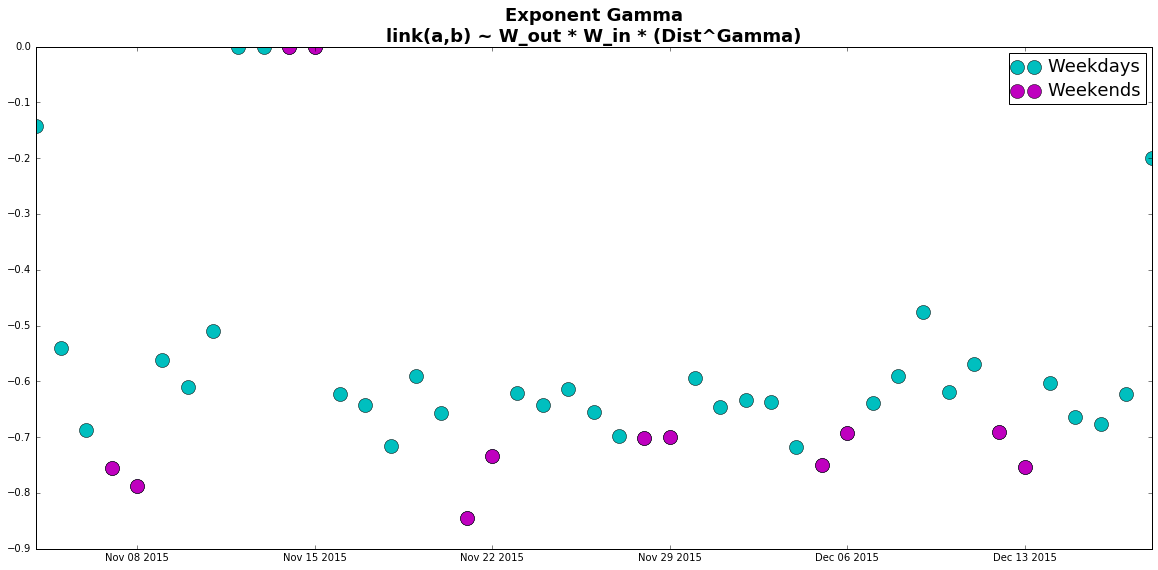

In [226]:
plt.plot(DateList[:45], Exponent,'co', markersize = 14, label = 'Weekdays')
plt.plot(DateList[:45], Exponent,'mo', markersize = 14, label = 'Weekends',markevery = markers_on)
plt.title('Exponent Gamma\nlink(a,b) ~ W_out * W_in * (Dist^Gamma)', fontsize = 18, weight = 'bold')
plt.legend(loc=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=18)
plt.show()

## The zeros indicate lack of data on that particular day. 